In [604]:
import os
import pyodbc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mpl_toolkits.basemap import Basemap
from sklearn import feature_selection, linear_model, cross_validation, tree, ensemble, metrics, externals

%matplotlib inline
sns.set_context("talk")

In [605]:
df = pd.read_csv('C:/Users/Daniel/Documents/Programming/sf_food/data_mean.csv')
#df = pd.read_csv('C:/Users/dhildebrand/sf_food/data_mean.csv')
df.fillna("",inplace=True)

In [606]:
df.head()

,business_id,name,yname,yid,latitude,longitude,ylat,ylong,cneighborhood,yprice_category,price_min,ccategory,insp_count,score,ycount,yrating
0,19,NRGIZE LIFESTYLE CAFE,Nrgize,nrgize-san-francisco,37.7868,-122.422,37.786945,-122.420982,nobhill,1,$0.00,coffeetea,4,94.5,19,4.0
1,24,OMNI S.F. HOTEL,Omni San Francisco,omni-san-francisco-san-francisco,37.7929,-122.403,37.792877,-122.402827,financialdistrict,3,$31.00,venue,4,97.0,471,4.5
2,31,NORMAN'S ICE CREAM AND FREEZES,Norman's Ice Cream & Freezes,normans-ice-cream-and-freezes-san-francisco,37.8072,-122.419,37.807278,-122.419472,russianhill,1,$0.00,desserts,3,94.0,211,4.5
3,45,CHARLIE'S DELI CAFE,Charlie's Deli Cafe,charlies-deli-cafe-san-francisco,37.7471,-122.414,37.747163,-122.413895,bernalheights,1,$0.00,fastfood,4,87.5,76,4.0
4,48,ART'S CAFE,Art's Cafe,arts-cafe-san-francisco,37.764,-122.466,37.763926,-122.465758,sunset,1,$0.00,american,3,92.0,963,4.0


## Data Cleanup

#### Observation
The business info list is messy. There is a lot of manually entered text so formatting is inconsistent. The next several cells are cleaning of this portion of the dataframe. A consistent name field is needed to identify whether or not a business has multiple locations within San Francisco (aka 'chain').

In [607]:
# Drop businesses with less than X Yelp reviews
print(len(df))
df = df.loc[df.ycount >= 10]
print(len(df))

3418
3230


In [608]:
# Convert strings to lowercase to avoid case sensitivity
for col in ['name','yname']:
    df[col] = df[col].str.lower()

def CleanName(field):
    # Remove apostrophe marks, commas, periods, llc from name
    df[field] = df[field].str.replace("'","")
    df[field] = df[field].str.replace(",","")
    df[field] = df[field].str.replace(".","")
    df[field] = df[field].str.replace(" llc","")
    df[field] = df[field].str.replace(" inc","")

    # Convert dashes, slashes, # to space
    df[field] = df[field].str.replace("-"," ")
    df[field] = df[field].str.replace("/"," ")
    df[field] = df[field].str.replace("#"," ")

    # Convert ampersand, plus to 'and'
    df[field] = df[field].str.replace("&"," and ")
    df[field] = df[field].str.replace("+"," and ")

    # Convert @ to 'at'
    df[field] = df[field].str.replace("@"," at ")

    # Remove leading and trailing whitespace
    df[field] = df[field].str.strip()
    
    return df

df = CleanName('name')
df = CleanName('yname')

In [609]:
# Check that name and yname are similar
split1 = df.name.str.split()
split2 = df.yname.str.split()

def CheckNameMatch(i):
    b1 = split1[i]
    b2 = split2[i]
    if len(b2) == 0:
        return True
    else:
        inter = set(b1).intersection(b2)
        return len(inter)>=1


df['name_match'] = pd.Series([CheckNameMatch(i) for i in split1.index],index=split1.index)

# Drop rows where the Yelp data doesn't match the correct business
print(len(df))
df = df[df['name_match']]
print(len(df))

3230
2997


In [610]:
# Handle businesses that are chains
def FindChains(name):
    if pd.isnull(name):
        return np.nan
    
    if '7 eleven' in name:
        return '7 eleven'
    if 'afc sushi' in name:
        return 'afc sushi'
    if 'annies hot dogs' in name:
        return 'annies hot dogs'
    if 'bacon bacon' in name:
        return 'bacon bacon'
    if 'bon appetit' in name:
        return 'bon appetit'
    if 'burger king' in name:
        return 'burger king'
    if 'chipotle mex' in name:
        return 'chipotle mexican grill'
    if 'coffee bar' in name:
        return 'coffee bar'
    if 'starbuck' in name:
        return 'starbucks'
    if 'mollie stones' in name:
        return 'mollie stones'
    if ('moscone' in name) & ('center' in name):
        return 'moscone center'
    if 'safeway' in name:
        return 'safeway'
    if 'subway' in name:
        return 'subway'
    if 'whole foods' in name:
        return 'whole foods market'
    if 'mcdonalds' in name:
        return 'mcdonalds'
    if 'la mediterranee' in name:
        return 'la mediterranee'
    if 'la boulangerie' in name:
        return 'la boulangerie'
    if ('cvs' in name) & ('pharmacy' in name):
        return 'cvs pharmacy'
    else:
        return name
    
df.name = df.name.apply(FindChains)

In [718]:
# Chains
df.name.value_counts().head()

starbucks                 42
subway                    30
peets coffee  and  tea    21
safeway                   13
7 eleven                  12
Name: name, dtype: int64

In [613]:
# Add feature 'chain' to indicate whether there is more than one restaurant in the city. 
# Note that a business could of course be a true chain with only 1 restaurant in the city and more locations elsewhere.
chains = (df.name.value_counts()[(df.name.value_counts()>=2)]).index
df['chain'] = df.name.isin(chains)*1

In [614]:
# Drop AT&T Park edge cases; phone numbers are identical, messy naming, and same address = no reliable way to query Yelp
pattern = r'at and t'
attpark = df.name.str.contains(pattern, na=False)
df.drop(attpark[attpark==True].index, inplace=True)

In [615]:
# Normalize and categorize the response vector, score2, and the prior inspection score, score1.
score = 'score'
    
# Bin scores according to SF Department of Health guidelines
number = df[score]
level_1 = (number < 70)                    # Poor
level_2 = ((number >= 70) & (number < 85)) # Needs improvement
level_3 = ((number >= 85) & (number < 90)) # Adequate

label = score+'_category'
df[label] = 4              # Good
df.loc[level_1, label] = 1 # Poor
df.loc[level_2, label] = 2 # Needs improvement
df.loc[level_3, label] = 3 # Adequate

In [616]:
# Bin by the number of ratings, ycount
number = df.ycount
level_1 = (number < 100)                    
level_2 = ((number >= 100) & (number < 236))
level_3 = ((number >= 236) & (number < 558))
level_4 = ((number >= 558) & (number < 1320))

label = 'ycount_category'
df[label] = 5              # Highest level (# of ratings)
df.loc[level_1, label] = 1 # Lowest level (# of ratings)
df.loc[level_2, label] = 2
df.loc[level_3, label] = 3
df.loc[level_4, label] = 4

In [617]:
# Create dummy variables
price_df = pd.get_dummies(df.yprice_category, prefix = 'price')
category_df = pd.get_dummies(df.ccategory, prefix = 'c')
neighborhood_df = pd.get_dummies(df.cneighborhood, prefix = 'n')
rating_df = pd.get_dummies(df.yrating, prefix = 'rating')
ycount_df = pd.get_dummies(df.ycount_category, prefix = 'ycount')

df = df.join([price_df, category_df, neighborhood_df, rating_df, ycount_df])

### Split into Train/Test

In [622]:
# Split into train/test dataframes
train = df.sample(frac = .8, random_state = 0)
test = df.drop(train.index)

## Exploratory Data Analysis

In [623]:
train.columns

Index([u'business_id', u'name', u'yname', u'yid', u'latitude', u'longitude',
       u'ylat', u'ylong', u'cneighborhood', u'yprice_category', u'price_min',
       u'ccategory', u'insp_count', u'score', u'ycount', u'yrating',
       u'name_match', u'chain', u'norm_score', u'score_category',
       u'ycount_category', u'price_1', u'price_2', u'price_3', u'price_4',
       u'c_african', u'c_american', u'c_asian', u'c_bakeries', u'c_bars',
       u'c_chinese', u'c_coffeetea', u'c_desserts', u'c_european',
       u'c_fastfood', u'c_french', u'c_grocery', u'c_indian', u'c_ingredients',
       u'c_italian', u'c_japanese', u'c_korean', u'c_latinamerican',
       u'c_mexican', u'c_middleeastern', u'c_seafood', u'c_thai',
       u'c_vegetarian', u'c_venue', u'c_vietnamese', u'n_bayviewhunterspoint',
       u'n_bernalheights', u'n_castro', u'n_chinatown', u'n_downtown',
       u'n_excelsior', u'n_financialdistrict', u'n_haight', u'n_marina',
       u'n_mission', u'n_nobhill', u'n_noevalley', u'n_n

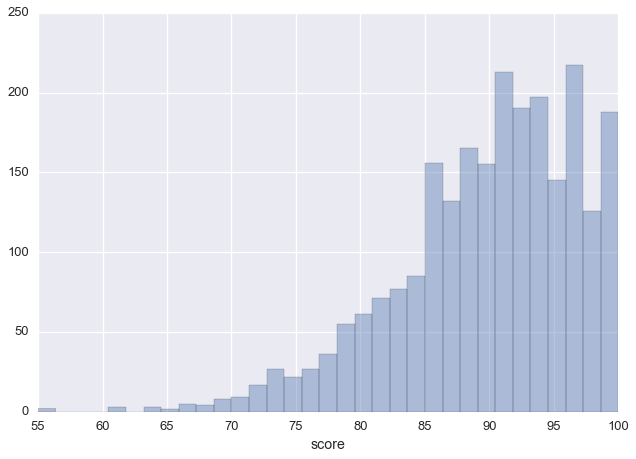

In [624]:
ax = sns.distplot(train.score,norm_hist=False, kde=False)

In [674]:
df.score.describe()

count    2997.000000
mean       89.834311
std         7.051483
min        55.000000
25%        85.750000
50%        91.000000
75%        95.000000
max       100.000000
Name: score, dtype: float64

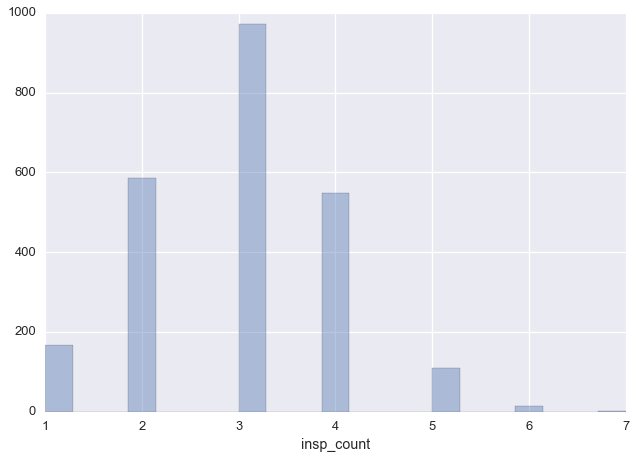

In [625]:
ax = sns.distplot(train.insp_count,norm_hist=False, kde=False)

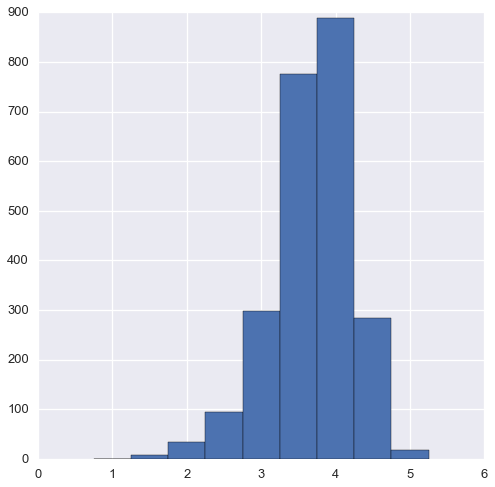

In [719]:
hist_yrating = train['yrating'].hist(bins=np.arange(0.75,5.75,.5),figsize=(8,8))

(50, 105)

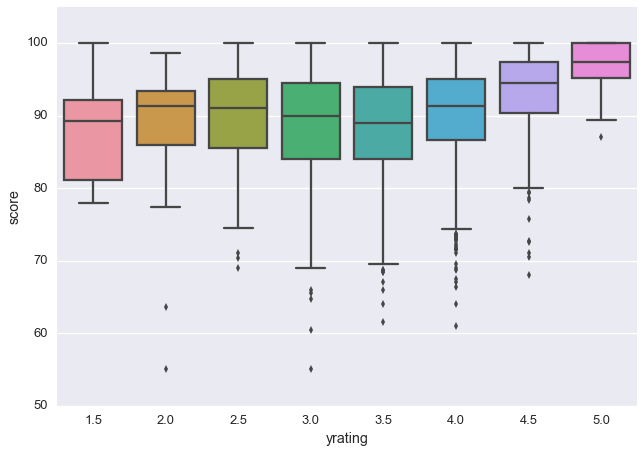

In [627]:
ax = sns.boxplot(x="yrating", y="score", data=train, whis=1.5)
ax.set_ylim(50,105)

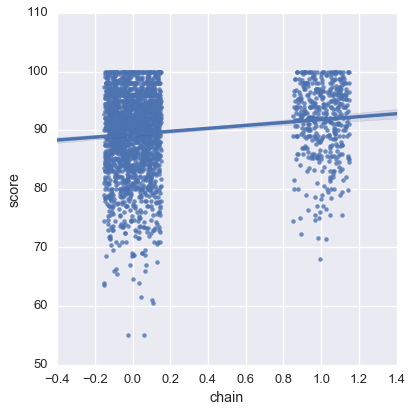

In [754]:
chain_plot = sns.lmplot(x='chain', y='score',data=train, x_jitter=.15, size=6)

In [698]:
df.sort_values('ycount',ascending=False)[['yname','score','ycount','ccategory','cneighborhood','yrating','yprice_category','chain']].head(10)

,yname,score,ycount,ccategory,cneighborhood,yrating,yprice_category,chain
1564,bi rite creamery,92.75,9051,desserts,mission,4.5,1,0
898,tartine bakery and cafe,96.67,6450,bakeries,mission,4.0,2,0
454,burma superstar,90.50,5715,asian,richmond,4.0,2,0
825,house of prime rib,94.67,5403,american,nobhill,4.0,3,0
2559,san tung,72.00,5267,chinese,sunset,4.0,2,0
817,gary danko,90.00,4559,american,russianhill,4.5,4,0
1391,the slanted door,89.25,4533,vietnamese,northbeach,3.5,3,0
698,foreign cinema,93.33,4015,american,mission,4.0,3,0
559,el farolito,88.60,3925,mexican,mission,4.0,1,1
121,the house,85.00,3847,asian,northbeach,4.5,3,0


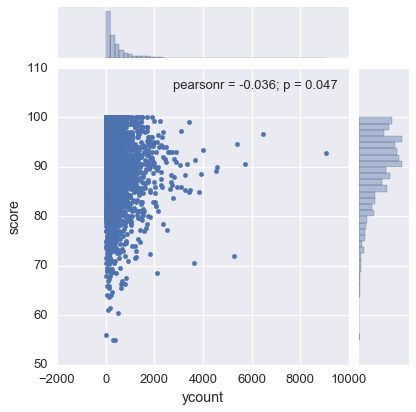

In [753]:
plot_ycount = sns.jointplot(x='ycount', y='score', data=df, kind='scatter', size=6)

(50, 105)

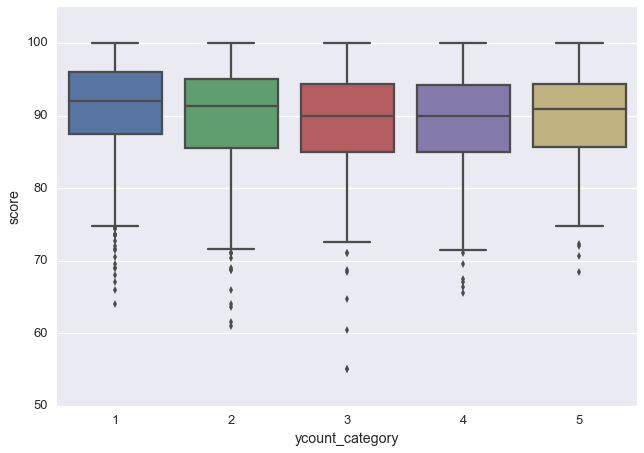

In [632]:
ax = sns.boxplot(x="ycount_category", y="score", data=train, whis=1.5)
ax.set_ylim(50,105)

### Price Point

(50, 105)

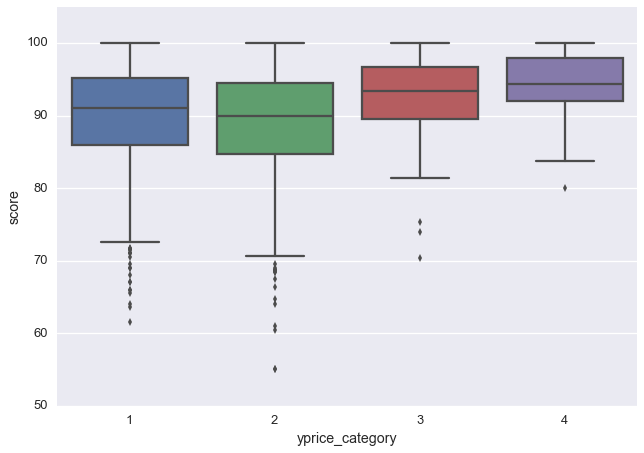

In [634]:
ax = sns.boxplot(x="yprice_category", y="score", data=train, whis=1.5)
ax.set_ylim(50,105)

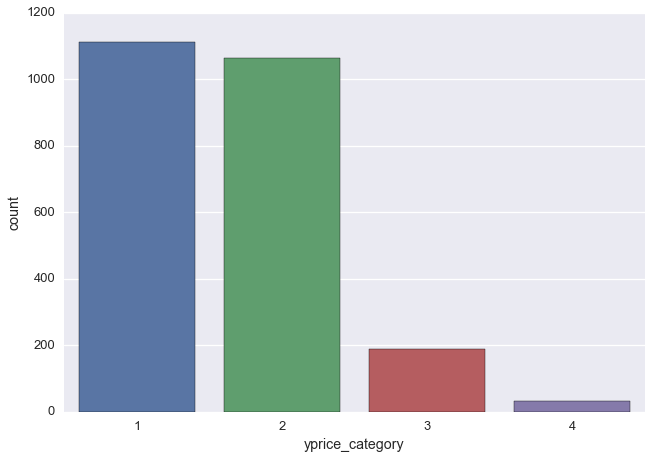

In [635]:
ax = sns.countplot(x="yprice_category", data=train)

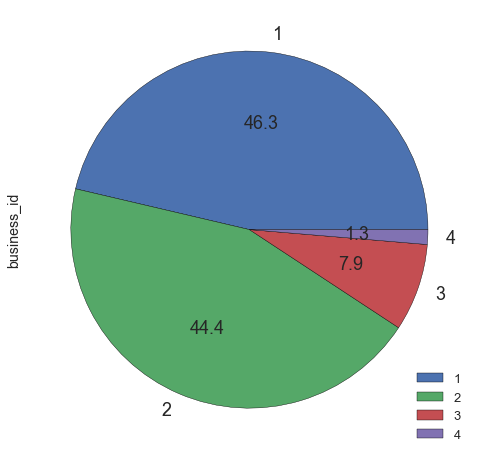

In [636]:
pie = train.groupby('yprice_category').count().plot.pie(y='business_id',figsize=(8,8),autopct='%.1f', fontsize=18)

##### Observation
There is a difference between the 2 lower price points and the 2 highest. As expected, more expensive businesses have higher scores. However, over 90% of the businesses are at price point 1 or 2 so this may not be a good global predictor.

### Category (Cuisine)

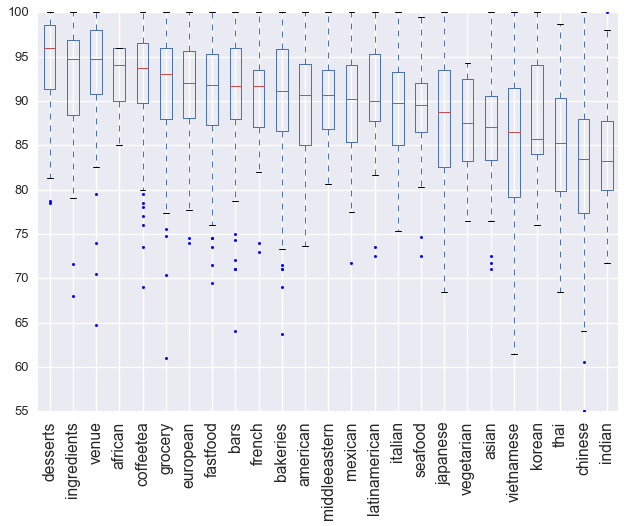

In [637]:
grouped = train.groupby('ccategory')
df2 = pd.DataFrame({col:vals['score'] for col,vals in grouped})
meds = df2.median().sort_values(ascending=False)
df2 = df2[meds.index]
df2.boxplot(return_type='axes',rot=90, sym='k.')

plt.show()

#### Observation
Some categories perform far below average.

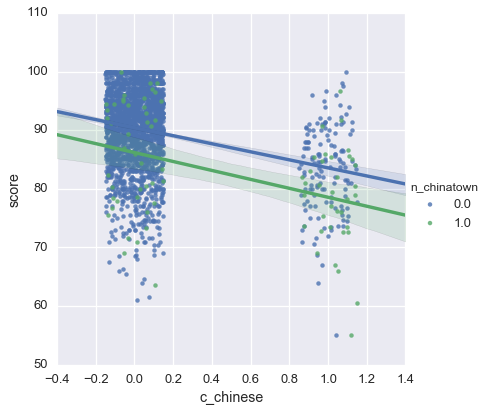

In [633]:
chinese_plot = sns.lmplot(x='c_chinese', y='score', hue='n_chinatown', data=train, x_jitter=.15, size=6)

#### Observation
Chinese scores lower overall in comparison to other categories, and everything scores lower in Chinatown. So Chinese in Chinatown would be expected to score poorly.

In [638]:
# Rank score grouped by category and normalized to the overall median norm_score
# I.E. scores less than 1 are worse than the median:
grouped = train.groupby('ccategory')
cat_rank = (grouped.norm_score.median()/train.norm_score.median()).sort_values()
print('Lowest scores:')
print(cat_rank.head())
print('\nHighest scores:')
print(cat_rank.tail())

Lowest scores:
ccategory
indian        0.782361
chinese       0.791667
thai          0.840278
korean        0.851806
vietnamese    0.875000
Name: norm_score, dtype: float64

Highest scores:
ccategory
coffeetea      1.074167
african        1.083333
venue          1.101944
ingredients    1.103056
desserts       1.138889
Name: norm_score, dtype: float64


In [639]:
# Looking at the worst performing categories, where are most of them located and the median normalized score there:
group_catneighborhood = train.groupby(['ccategory','cneighborhood'])[['norm_score']].median() / \
                        train.groupby(['ccategory'])[['norm_score']].median()
group_catneighborhood['ccount'] = train.groupby(['ccategory','cneighborhood'])[['norm_score']].count()
for cat in cat_rank[cat_rank<1].index:
    print('\n-----------')
    print(cat)
    temp = group_catneighborhood.loc[cat]
    temp = temp[(temp.norm_score<=1) & (temp.ccount>1)]
    print(temp.sort_values(['norm_score'],ascending=True).sort_values(['ccount'],ascending=False).head(5))


-----------
indian
               norm_score  ccount
cneighborhood                    
downtown         0.896503       5
mission          0.994142       5
richmond         0.852121       3
castro           0.757500       2

-----------
chinese
               norm_score  ccount
cneighborhood                    
chinatown        0.850877      36
richmond         0.979474      28
mission          0.947368      10
nobhill          0.842105       5
northbeach       0.771930       4

-----------
thai
                 norm_score  ccount
cneighborhood                      
downtown           0.859504      11
soma               0.727273       7
nobhill            0.959835       6
haight             0.958678       5
westernaddition    0.611570       2

-----------
korean
                norm_score  ccount
cneighborhood                     
sunset            0.913093       4
nobhill           0.945704       3
pacificheights    0.945704       3
downtown          0.962009       2

-----------
viet

##### Observation
Only a few neighborhoods really standout with poor category scores: Chinese in Chinatown, Indian in the Richmond, Korean in the Sunset, and Vietnamese Downtown.

In [640]:
# Difference between median scores for the lowest price and highest price by category
cat_price = train.groupby(['ccategory','yprice_category'])[['score']].median().mean(axis=1)
index = cat_price.index.get_level_values(0).unique()
catmax = pd.Series([cat_price.loc[cat].loc[cat_price.loc[cat].index.max()] 
          for cat in index],index=index)
catmin = pd.Series([cat_price.loc[cat].loc[cat_price.loc[cat].index.min()] 
          for cat in index],index=index)
cat_price_delta = catmax - catmin
cat_price_delta.sort_values(ascending=False).head(10)

seafood        8.330
italian        7.605
venue          5.420
japanese       4.670
bakeries       4.335
indian         4.270
ingredients    4.165
french         3.835
vietnamese     3.795
american       2.670
dtype: float64

##### Observation
Increasing the price point positively correlates with a better score for many cuisines but mainly cuisines which score lower on average and have a wide range of price points.

### Location / proximity

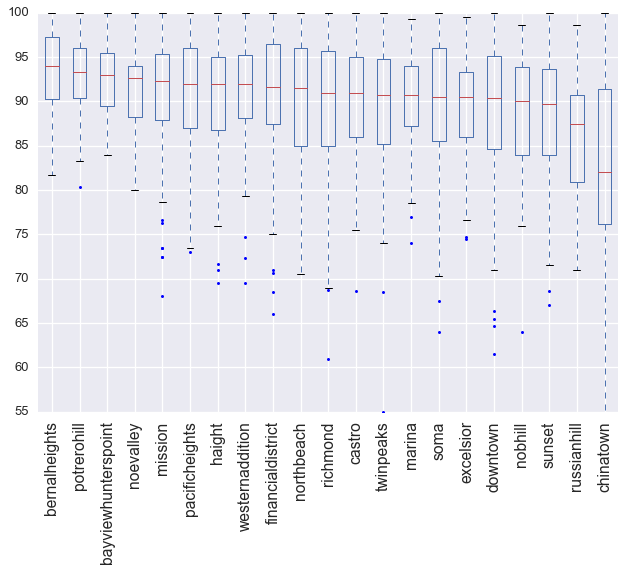

In [641]:
# Look at Score grouped by neighborhood
grouped = train.groupby('cneighborhood')
df2 = pd.DataFrame({col:vals['score'] for col,vals in grouped})
meds = df2.median().sort_values(ascending=False)
df2 = df2[meds.index]
df2.boxplot(return_type='axes',rot=90, sym='k.')
plt.show()

##### Observation
Only a few neighborhoods appear to have lower scores than the average. Chinatown & Russian Hill appear to be outliers.

In [642]:
# Function to look at scores by neighborhood by cuisine category.
def NeighborhoodCuisine(neighborhood):
    print('-----------------')
    cats = train[(train.cneighborhood==neighborhood)].ccategory.unique()
    print('Mean Score in %s: %.1f'%
          (neighborhood, train[(train.cneighborhood==neighborhood)].score.mean()))
    print('Mean Score not in %s: %.1f\n'%
          (neighborhood, train[(train.cneighborhood!=neighborhood)].score.mean()))
    for cat in cats:
        # Only look at categories where there are more than just a couple of businesses to limit skewed comparisons.
        if train[(train.cneighborhood==neighborhood) & (train.ccategory==cat)].name.count()>2:
            print('Mean Score for %s category in %s: %.1f'%
                  (cat, neighborhood,
                    train[(train.cneighborhood==neighborhood) & (train.ccategory==cat)].score.mean()))
            print('Mean Score for %s category not in %s: %.1f\n'%
                  (cat, neighborhood,
                    train[(train.cneighborhood!=neighborhood) & (train.ccategory==cat)].score.mean()))

# Looking at Chinatown vs. a higher scoring neighborhood just for reference:
NeighborhoodCuisine('chinatown')
NeighborhoodCuisine('potrerohill')

-----------------
Mean Score in chinatown: 82.7
Mean Score not in chinatown: 90.0

Mean Score for chinese category in chinatown: 78.6
Mean Score for chinese category not in chinatown: 83.6

Mean Score for bakeries category in chinatown: 75.8
Mean Score for bakeries category not in chinatown: 91.3

Mean Score for coffeetea category in chinatown: 90.9
Mean Score for coffeetea category not in chinatown: 92.7

Mean Score for venue category in chinatown: 94.1
Mean Score for venue category not in chinatown: 93.5

Mean Score for japanese category in chinatown: 88.2
Mean Score for japanese category not in chinatown: 87.8

Mean Score for fastfood category in chinatown: 94.9
Mean Score for fastfood category not in chinatown: 90.8

Mean Score for vietnamese category in chinatown: 84.6
Mean Score for vietnamese category not in chinatown: 85.0

-----------------
Mean Score in potrerohill: 92.7
Mean Score not in potrerohill: 89.7

Mean Score for bars category in potrerohill: 96.5
Mean Score for bars

##### Observation
Chinese restaurants in Chinatown only have slightly lower scores than in other neighborhoods while Bakeries in Chinatown have much lower scores than in other neighborhoods.

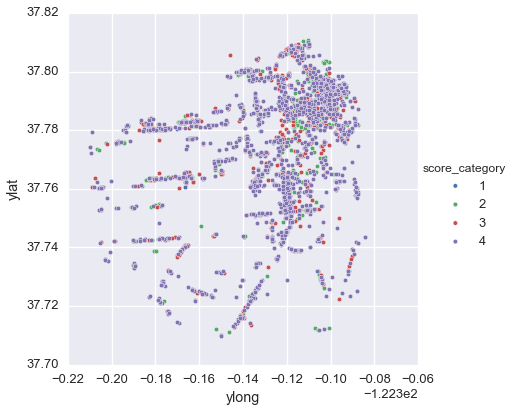

In [643]:
plot = df
plot = plot[(plot.ylong < -122.38) & (plot.ylat > 37.7)]
plot = plot[(plot.ylat < 37.9)]
map_plot = sns.pairplot(data=plot,x_vars=['ylong'],y_vars=['ylat'],hue='score_category',size=6)

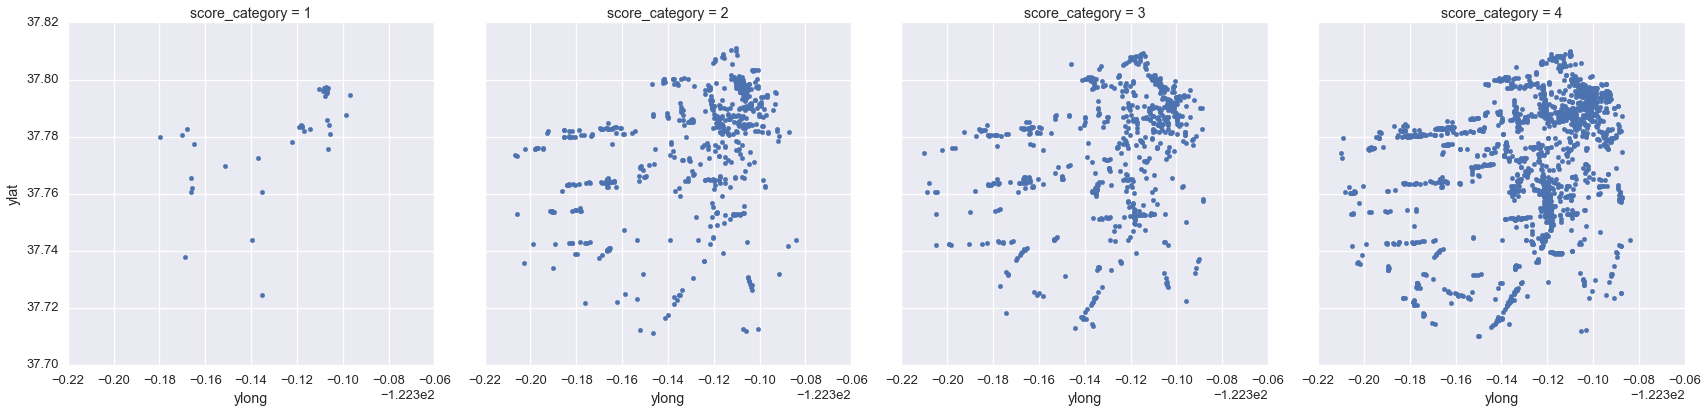

In [645]:
g = sns.FacetGrid(plot, col="score_category",size=6)
g.map(plt.scatter, "ylong", "ylat")

## Modeling

In [646]:
def PlotResidual(df):
    x = 'score_test'
    y = 'residual'
    df = df.ix[test_X.index]
    
    df.plot(y='score',x=x,kind='scatter',ylim=(70,105),xlim=(70,105),figsize=(10,5))
    plt.plot([0,110],[0,110],'k-')
    
    df.plot(x,y,kind='scatter',xlim=(70,105),ylim=(-1,14),figsize=(10,5))
    plt.plot([0,110],[baseline.mean(),baseline.mean()],'k-')
    plt.plot([0,110],[df[y].mean(),df[y].mean()],'r--')
    
    
def PlotTraining():
    d = {'num_features':num_features,'val_score':val_scores, 'train_score':train_scores, 
         'features':features_list, 'baseline':baseline.mean()}
    model_score_df = pd.DataFrame(d)
    ax = model_score_df.plot(x='num_features',y='train_score',label='training',color='blue',figsize=(15,5))
    model_score_df.plot(x='num_features',y='val_score',label='validation',color='red',ax=ax)
    model_score_df.plot(x='num_features',y='baseline',label='baseline',color='black',ax=ax)
    ax.set_ylim(4,5.6)
    return model_score_df

def X_y(df,names_X,y):
    X = df[names_X]
    y = df[y]
    return X, y

### Baseline

In [648]:
baseline = np.abs(test.score.mean()-test.score)
baseline.describe()

count    599.000000
mean       5.398292
std        4.433541
min        0.055576
25%        2.055576
50%        4.385576
75%        7.944424
max       34.055576
Name: score, dtype: float64

### Linear Regression



59
(2.3369814720120943e-38, 'c_chinese')
(4.1151722718289086e-14, 'n_chinatown')
(9.4698390858787848e-13, 'rating_4.5')
(2.8608835961954617e-08, 'chain')
(6.4556654999441639e-08, 'c_coffeetea')
(1.4796176897742082e-07, 'rating_3.5')
(1.8465482407046809e-07, 'price_3')
(1.9433627203751023e-07, 'c_venue')
(1.333440643443161e-06, 'c_thai')
(7.2310688934445473e-06, 'c_vietnamese')
(1.2252665870814349e-05, 'n_russianhill')
(4.6544796981273112e-05, 'price_2')
(0.00022800793582482327, 'c_desserts')
(0.00061276232024998266, 'n_financialdistrict')
(0.00085568676743453978, 'rating_5.0')
(0.0019693130926388574, 'c_fastfood')
(0.0023706314807733948, 'n_bernalheights')
(0.0041283884333557031, 'insp_count')
(0.0049447853027097602, 'c_asian')
(0.0051805469047303942, 'c_indian')
(0.0071466215368948191, 'n_mission')
(0.0096578901193597241, 'price_4')
(0.010497626642586255, 'rating_3.0')
(0.019293743077800737, 'c_grocery')
(0.027420152334541589, 'n_potrerohill')
(0.032080643840871829, 'rating_4.0')
(0

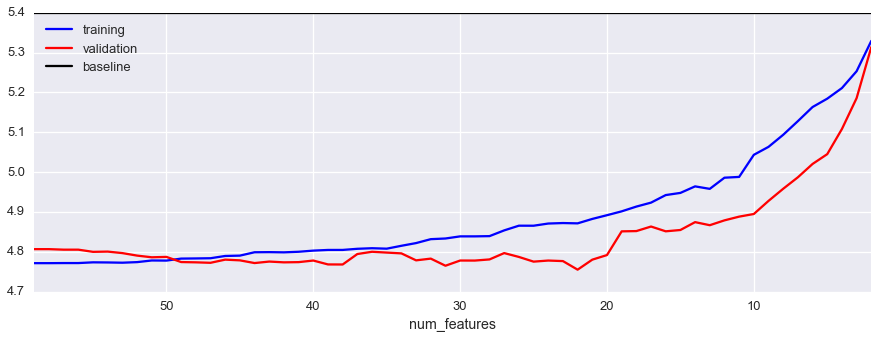

In [732]:
# Start with the all the features...
y='score'
max_features=1
features_keep = ['chain', 'insp_count', 'ycount',
                 'rating_2.0', 'rating_2.5', 'rating_3.0', 'rating_3.5', 'rating_4.0', 'rating_4.5', 'rating_5.0',
                 #'ycount_2', 'ycount_3', 'ycount_4', 'ycount_5',
                 'price_2', 'price_3', 'price_4'] + list(category_df.columns) + list(neighborhood_df.columns)

val_scores = []
train_scores = []
num_features = []
features_list = []

while len(features_keep) > max_features:

    names_X = features_keep
    print('\n')
    print(len(names_X))
    
    train_X, train_y = X_y(train,names_X,y)
    train_X, test_X, train_y, test_y = cross_validation.train_test_split(train_X, train_y, train_size = 0.7, random_state = 0)

    clf = linear_model.LinearRegression()
    clf.fit(train_X, train_y)

    train_y_hat = clf.predict(train_X)
    test_y_hat = clf.predict(test_X)
    train_resid = train_y-train_y_hat
    test_resid = test_y-test_y_hat

    train[y+'_test'] = pd.Series(test_y_hat,index=test_X.index)
    train[y+'_train'] = pd.Series(train_y_hat,index=train_X.index)
    train['residual'] = np.abs(pd.concat([train_resid,test_resid]))

    features = sorted(zip(feature_selection.f_regression(train_X, train_y)[1],train_X.columns.values))
    for f in features:
        print(f)

    #PlotResidual(train)
    
    val_score = np.abs(test_resid)
    train_score = np.abs(train_resid)
    val_scores.append(val_score.mean())
    train_scores.append(train_score.mean())
    num_features.append(len(features))
    features_list.append(features_keep)

    print('Train MAE: %.2f' % (train_score.mean()))
    print('Test MAE: %.2f' % (val_score.mean()))
    
    # Remove the lowest rank feature and continue loop
    features_keep = []
    for f in features[0:-1]:
        features_keep.append(f[1])

lmodel_score_df = PlotTraining()

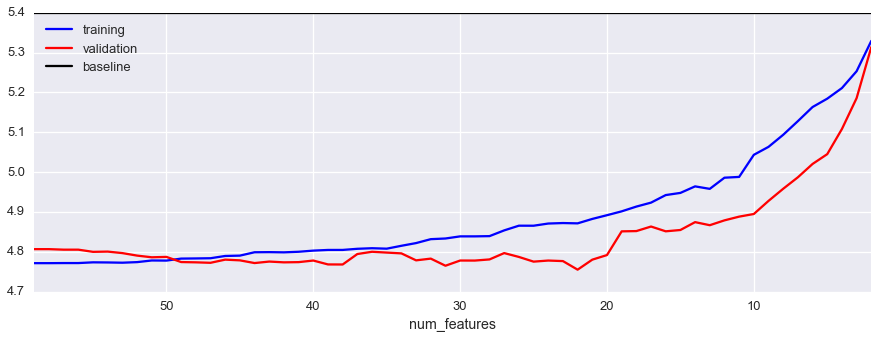

In [733]:
lmodel_score_df = PlotTraining()

In [740]:
# Final training
y='score'

names_X = lmodel_score_df[lmodel_score_df.num_features==29].features.values[0]

train_X, train_y = X_y(train,names_X,y)

clf = linear_model.LinearRegression()
clf.fit(train_X, train_y)

train_y_hat = clf.predict(train_X)
train_resid = train_y-train_y_hat

features = (sorted(zip(feature_selection.f_regression(train_X, train_y)[1],train_X.columns.values)))
for f in features:
    print(f)

print(np.abs(train_resid).describe())

(1.810894717139152e-46, 'c_chinese')
(7.2285477679285451e-20, 'n_chinatown')
(3.0320814941594692e-18, 'rating_4.5')
(3.9937047952153105e-14, 'c_coffeetea')
(1.0833529253459801e-11, 'chain')
(3.7961835364454637e-11, 'rating_3.5')
(2.8215529367003095e-10, 'c_venue')
(1.005588355444725e-09, 'c_thai')
(1.0717760243754801e-09, 'price_3')
(1.5998268265255936e-08, 'c_vietnamese')
(9.006843133751674e-08, 'price_2')
(1.3686555097935e-06, 'c_indian')
(2.0700553858507486e-06, 'c_desserts')
(4.0915394735824555e-06, 'n_russianhill')
(7.5880180054662327e-05, 'rating_5.0')
(0.00023091715880025794, 'n_mission')
(0.00040909974942875712, 'n_bernalheights')
(0.00064214295416450951, 'n_financialdistrict')
(0.00076069604792101497, 'price_4')
(0.0011117470575030132, 'c_japanese')
(0.001319635793739738, 'c_fastfood')
(0.0016738527093267197, 'insp_count')
(0.0038915225910515867, 'rating_3.0')
(0.005914424290869965, 'c_asian')
(0.014441365848194495, 'c_grocery')
(0.015171515966960245, 'c_bars')
(0.017443323923

count    599.000000
mean       4.945300
std        3.991743
min        0.004108
25%        1.987585
50%        4.013620
75%        6.891833
max       32.673429
Name: score, dtype: float64


% improvement over baseline: 8.4


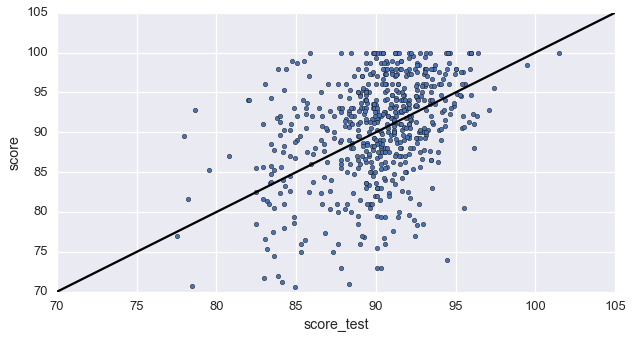

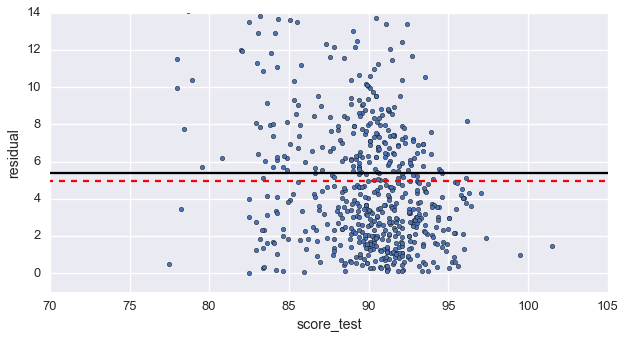

In [741]:
# Test set
df_local = test
test_X, test_y = X_y(df_local,names_X,y)

test_y_hat = clf.predict(test_X)
test_resid = test_y-test_y_hat

df_local[y+'_test'] = pd.Series(test_y_hat,index=test_X.index)
df_local['residual'] = np.abs(test_y-test_y_hat)

print(np.abs(test_resid).describe())
print('\n')
print('%% improvement over baseline: %.1f' %((1 - np.abs(test_resid).mean()/baseline.mean())*100))

PlotResidual(df_local)

(-2, 40)

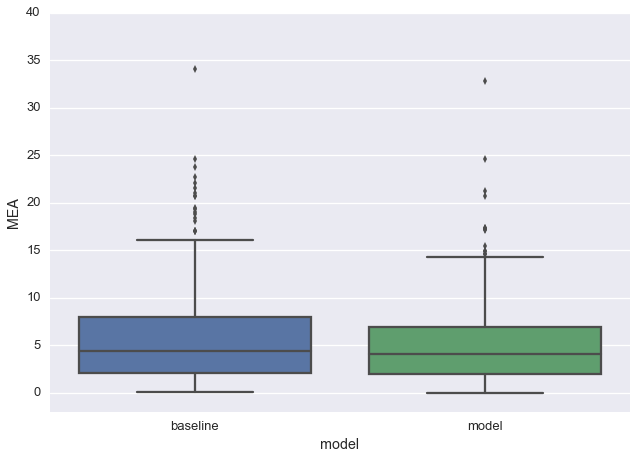

In [739]:
a = pd.DataFrame({'MEA':baseline, 'model': 'baseline'})
a.reset_index(inplace=True)
b = pd.DataFrame({'MEA':df_local.residual, 'model': 'model'})
b.reset_index(inplace=True)
ax = sns.boxplot(y='MEA',x='model', data=pd.concat([a,b]), whis=1.5)
ax.set_ylim(-2,40)

In [695]:
df_local['delta'] = df_local.score_test - df_local.score
df_l = df_local

# Under predicted (model predicted lower scores than actual)
df_l.sort_values('delta',ascending=True)[['yname','score','score_test','ycount','ccategory','cneighborhood','yrating','yprice_category','chain']].head()

,yname,score,score_test,ycount,ccategory,cneighborhood,yrating,yprice_category,chain
459,panda express,100.00,85.387588,57,chinese,sunset,2.5,1,1
2430,aslams rasoi,99.00,84.732348,810,indian,mission,4.0,2,0
2315,thai cottage restaurant,98.67,84.417342,179,thai,sunset,4.0,2,0
866,oriental pearl restaurant,92.75,78.686799,303,chinese,chinatown,3.5,2,0
2795,backroom dining,98.00,83.983648,12,asian,twinpeaks,3.0,2,0


In [696]:
# Over predicted (model predicted higher scores than actual)
df_l.sort_values('delta',ascending=False)[['yname','score','score_test','ycount','ccategory','cneighborhood','yrating','yprice_category','chain']].head(10)

,yname,score,score_test,ycount,ccategory,cneighborhood,yrating,yprice_category,chain
273,taqueria la paz,56.00,88.767174,26,mexican,downtown,4.0,1,0
1588,bristol farms,66.33,91.057225,793,grocery,downtown,3.5,3,0
2563,roxies market and deli,69.33,89.934308,259,fastfood,sunset,4.0,1,0
1257,el chico produce no 2,74.00,94.499435,21,ingredients,mission,4.5,1,1
785,happy garden,65.50,82.891191,148,chinese,richmond,2.5,1,0
1273,rjs market levi plaza,73.00,90.388670,203,grocery,northbeach,3.0,3,0
951,cove on castro cafe,71.00,88.371984,222,american,castro,3.5,2,0
2893,sa beang thai,67.33,84.612201,133,thai,haight,3.5,2,0
2199,gateway croissant,73.00,90.152401,102,coffeetea,downtown,3.5,1,0
7,oasis grill,77.00,92.451744,1046,european,financialdistrict,4.0,1,1


### Random Forest



59
(0.17382688545662128, 'c_chinese')
(0.14197792067518192, 'ycount')
(0.063073890954164449, 'n_chinatown')
(0.056515828212029204, 'insp_count')
(0.045721571376624588, 'rating_4.5')
(0.041153901929813511, 'c_thai')
(0.037560067357132493, 'chain')
(0.032925778964675245, 'c_coffeetea')
(0.030871313298634521, 'rating_3.5')
(0.030180511051466265, 'c_vietnamese')
(0.02569884695015346, 'price_2')
(0.024880282332446355, 'c_venue')
(0.024127650305078276, 'n_russianhill')
(0.023890721966512003, 'rating_4.0')
(0.020801165723418169, 'price_3')
(0.018076024971912477, 'n_sunset')
(0.014774562234495458, 'rating_3.0')
(0.013984010448323328, 'n_mission')
(0.013972283779894257, 'c_fastfood')
(0.012731711260069502, 'c_japanese')
(0.012084250521695553, 'n_downtown')
(0.01086079622909625, 'n_financialdistrict')
(0.00976010366909307, 'c_bakeries')
(0.0081690274308816122, 'c_indian')
(0.008153442211071513, 'c_desserts')
(0.0076465879349737788, 'n_richmond')
(0.0069486484445219496, 'c_mexican')
(0.00632240

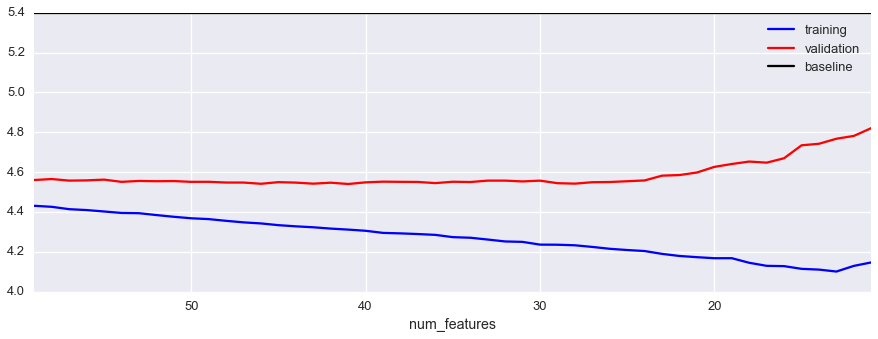

In [657]:
from sklearn.ensemble import RandomForestRegressor

# Note: This takes a long time to run. Disable by changing to 'RawNBConvert'

# Start with the all the features...
y='score'
max_features=10
features_keep = ['chain', 'insp_count', 'ycount', 
                'rating_2.0', 'rating_2.5', 'rating_3.0', 'rating_3.5', 'rating_4.0', 'rating_4.5', 'rating_5.0', 
                'price_2', 'price_3', 'price_4'] + list(category_df.columns) + list(neighborhood_df.columns)

val_scores = []
train_scores = []
num_features = []
features_list = []

while len(features_keep) > max_features:

    names_X = features_keep
    print('\n')
    print(len(names_X))
    
    train_X, train_y = X_y(train,names_X,y)
    train_X, test_X, train_y, test_y = cross_validation.train_test_split(train_X, train_y, train_size = 0.8, random_state = 0)

    clf = RandomForestRegressor(n_estimators=2000,
                                max_features=max_features,
                                min_samples_leaf = 5,
                                oob_score = True,
                                random_state = 0)
    clf = clf.fit(train_X, train_y)

    train_y_hat = clf.predict(train_X)
    test_y_hat = clf.predict(test_X)
    train_resid = train_y-train_y_hat
    test_resid = test_y-test_y_hat

    train[y+'_test'] = pd.Series(test_y_hat,index=test_X.index)
    train[y+'_train'] = pd.Series(train_y_hat,index=train_X.index)
    train['residual'] = np.abs(pd.concat([train_resid,test_resid]))

    features = (sorted(zip(clf.feature_importances_, train_X.columns.values), reverse = True))
    for f in features:
        print(f)
    
    val_score = np.abs(test_resid)
    train_score = np.abs(train_resid)
    val_scores.append(val_score.mean())
    train_scores.append(train_score.mean())
    num_features.append(len(features))
    features_list.append(features_keep)
    
    print('Train MAE: %.2f' % (train_score.mean()))
    print('Test MAE: %.2f' % (val_score.mean()))
    
    # Remove the lowest rank feature and continue loop
    features_keep = []
    for f in features[0:-1]:
        features_keep.append(f[1])
        
rfmodel_score_df = PlotTraining()

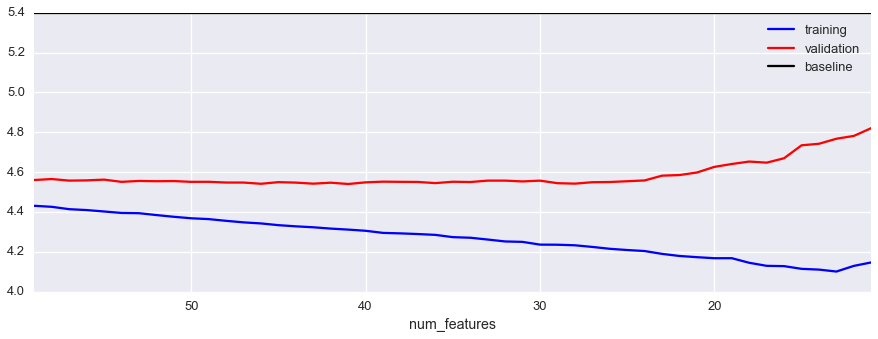

In [658]:
rfmodel_score_df = PlotTraining()

In [687]:
# Final training
y='score'

names_X = rfmodel_score_df[rfmodel_score_df.num_features==25].features.values[0]

train_X, train_y = X_y(train,names_X,y)

clf = RandomForestRegressor(n_estimators=4000,
                            max_features=max_features,
                            min_samples_leaf = 5,
                            oob_score = True,
                            random_state = 0)
clf = clf.fit(train_X, train_y)

train_y_hat = clf.predict(train_X)
train_resid = train_y-train_y_hat

features = (sorted(zip(clf.feature_importances_, train_X.columns.values), reverse = True))
for f in features:
    print(f)

print(np.abs(train_resid).describe())

(0.247371051354177, 'ycount')
(0.15428647804701678, 'c_chinese')
(0.079150603026356889, 'insp_count')
(0.049218886810544732, 'n_chinatown')
(0.048947010209391961, 'rating_4.5')
(0.039670410344537825, 'chain')
(0.031804850971310514, 'rating_3.5')
(0.03155675549994142, 'price_2')
(0.031247246620434502, 'c_thai')
(0.029654165461199405, 'c_coffeetea')
(0.029495270219807041, 'c_vietnamese')
(0.029104966431273343, 'rating_4.0')
(0.024056345719207003, 'c_venue')
(0.018660968325868079, 'n_russianhill')
(0.018467403694594556, 'n_sunset')
(0.016950788170764931, 'price_3')
(0.016046343554769988, 'c_japanese')
(0.015941848684407792, 'n_mission')
(0.014587310131382489, 'n_downtown')
(0.014379688518155279, 'rating_3.0')
(0.013524867229304972, 'c_indian')
(0.013513859673207793, 'c_fastfood')
(0.012616396335791084, 'n_financialdistrict')
(0.011341702062895842, 'c_bakeries')
(0.0084047829036590586, 'n_richmond')
count    2398.000000
mean        4.110686
std         3.298107
min         0.001798
25%    

count    599.000000
mean       4.777355
std        3.958995
min        0.002090
25%        1.812912
50%        3.834136
75%        6.604584
max       35.054029
Name: score, dtype: float64


% improvement over baseline: 11.5


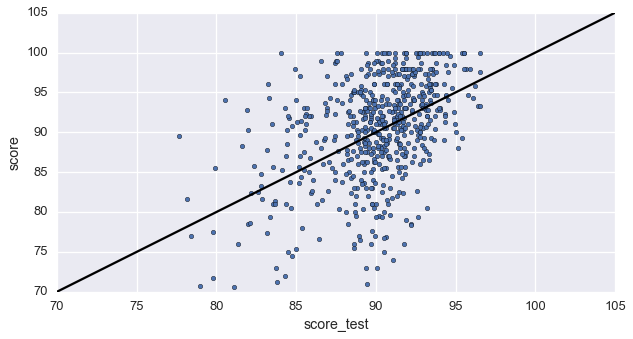

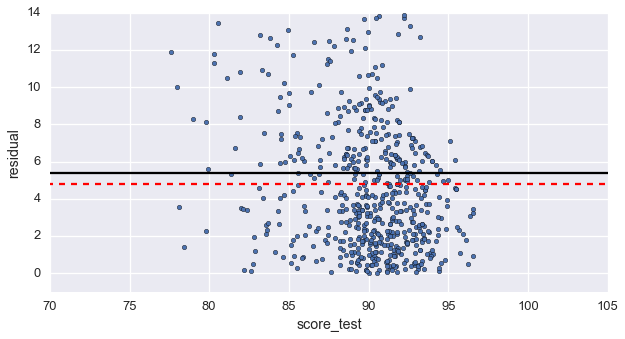

In [688]:
# Test set
df_local = test
test_X, test_y = X_y(df_local,names_X,y)

test_y_hat = clf.predict(test_X)
test_resid = test_y-test_y_hat

df_local[y+'_test'] = pd.Series(test_y_hat,index=test_X.index)
df_local['residual'] = np.abs(test_resid)

print(np.abs(test_resid).describe())
print('\n')
print('%% improvement over baseline: %.1f' %((1 - np.abs(test_resid).mean()/baseline.mean())*100))

PlotResidual(df_local)

(-2, 40)

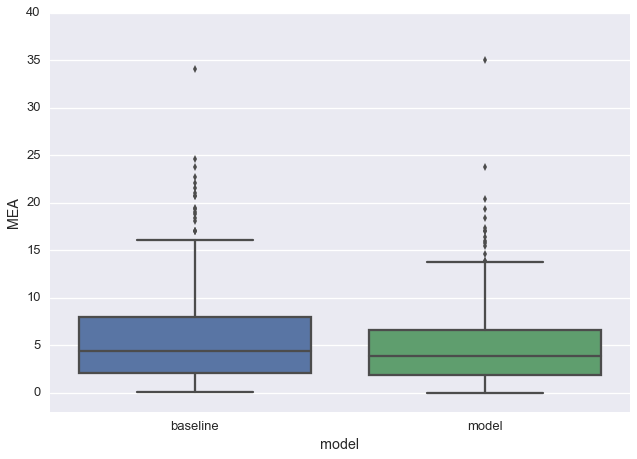

In [689]:
a = pd.DataFrame({'MEA':baseline, 'model': 'baseline'})
a.reset_index(inplace=True)
b = pd.DataFrame({'MEA':df_local.residual, 'model': 'model'})
b.reset_index(inplace=True)
ax = sns.boxplot(y='MEA',x='model', data=pd.concat([a,b]), whis=1.5)
ax.set_ylim(-2,40)

In [690]:
df_local['delta'] = df_local.score_test - df_local.score
df_rf = df_local

# Under predicted (model predicted lower scores than actual)
df_rf.sort_values('delta',ascending=True)[['yname','score','score_test','ycount','ccategory','cneighborhood','yrating','yprice_category','chain']].head()

,yname,score,score_test,ycount,ccategory,cneighborhood,yrating,yprice_category,chain
540,gold mirror italian restaurant,100.0,84.038106,213,italian,sunset,3.5,2,0
3338,t 28 bakery and cafe,94.0,80.552224,197,chinese,sunset,3.0,1,0
3398,yans kitchen,98.0,84.911949,392,chinese,financialdistrict,4.0,1,0
500,b and m mei sing restaurant,96.0,83.204686,228,chinese,financialdistrict,3.0,1,0
459,panda express,100.0,87.531577,57,chinese,sunset,2.5,1,1


In [691]:
# Over predicted (model predicted higher scores than actual)
df_rf.sort_values('delta',ascending=False)[['yname','score','score_test','ycount','ccategory','cneighborhood','yrating','yprice_category','chain']].head(10)

,yname,score,score_test,ycount,ccategory,cneighborhood,yrating,yprice_category,chain
273,taqueria la paz,56.00,91.054029,26,mexican,downtown,4.0,1,0
1588,bristol farms,66.33,90.093305,793,grocery,downtown,3.5,3,0
2893,sa beang thai,67.33,87.705460,133,thai,haight,3.5,2,0
2563,roxies market and deli,69.33,88.694850,259,fastfood,sunset,4.0,1,0
951,cove on castro cafe,71.00,89.435155,222,american,castro,3.5,2,0
785,happy garden,65.50,82.802818,148,chinese,richmond,2.5,1,0
1273,rjs market levi plaza,73.00,90.064174,203,grocery,northbeach,3.0,3,0
1257,el chico produce no 2,74.00,91.051120,21,ingredients,mission,4.5,1,1
2199,gateway croissant,73.00,89.348069,102,coffeetea,downtown,3.5,1,0
3192,wei lee chinese food and donuts,76.00,91.754760,59,fastfood,richmond,2.5,1,0
